In [4]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

from heapq import heappush, heappop

import matplotlib.cm as cm
from tqdm import tqdm
import polars as pl

import geopandas as gpd

from shapely.geometry import Point, Polygon
from shapely import wkt

import pandas as pd
import statsmodels.api as sm
import scipy
import scipy.optimize as opt
import seaborn as sns

from pyproj import Transformer

from bayesian_statistics.utils_2 import *
import japanize_matplotlib

from keplergl import KeplerGl

In [5]:
# polarsとしても読み込む
df_elevation = pl.read_csv("../data/9_gdf_elevation.csv")

In [6]:
df_elevation

mesh_code_5th,average_elevation,maximum_elevation,minimum_elevation,minimum_elevation_code,maximum_slope_angle,maximum_slope_direction,minimum_slope_angle,minimum_slope_direction,average_slope_angle,geometry,x,y
i64,f64,f64,f64,str,f64,str,f64,str,f64,str,f64,f64
5138709011,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((138 34.6583333356293…",138.001563,34.659375
5138709012,1.2,2.8,0.1,"""0""",2.1,"""5""",1.8,"""5""",2.0,"""POLYGON ((138.003125 34.658333…",138.004688,34.659375
5138709021,2.0,4.9,0.0,"""0""",5.0,"""5""",1.2,"""5""",2.5,"""POLYGON ((138.00625 34.6583333…",138.007812,34.659375
5138709022,3.6,10.5,0.0,"""0""",3.2,"""5""",0.9,"""5""",1.9,"""POLYGON ((138.009375 34.658333…",138.010938,34.659375
5138709013,3.3,12.7,0.0,"""0""",5.6,"""5""",0.1,"""7""",1.7,"""POLYGON ((138 34.6604166689627…",138.001563,34.661458
…,…,…,…,…,…,…,…,…,…,…,…,…
5540379842,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((140.98437500001108 3…",140.985938,36.996875
5540379833,19.9,49.4,6.2,"""0""",16.1,"""4""",0.5,"""4""",7.5,"""POLYGON ((140.97500000001108 3…",140.976563,36.998958
5540379834,12.6,50.2,0.3,"""0""",15.6,"""2""",1.4,"""2""",8.0,"""POLYGON ((140.9781250000111 36…",140.979688,36.998958


In [7]:
_map = KeplerGl(height=500)
gdf = df_elevation.filter(pl.col("average_elevation").is_null())
gdf = gdf.to_pandas()
gdf.geometry = gdf.geometry.apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry="geometry")
gdf.crs = "EPSG:4326"
_map.add_data(data=gdf, name="elevation")
_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'elevation': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…

In [8]:
def create_elevation_heatmap(df: pl.DataFrame, expr: pl.Expr, x_col: str, y_col: str, resolution: int = 500, cmap: str = 'terrain'):
    """
    ヒートマップを作成する関数
    
    Parameters:
    -----------
    df : pl.DataFrame
        x, y座標を含むDataFrame
    expr : pl.Expr
        プロットする値を計算するpolarsエクスプレッション
    x_col : str
        x座標のカラム名
    y_col : str
        y座標のカラム名
    resolution : int
        ヒートマップの解像度
    cmap : str
        カラーマップの名前
        
    Returns:
    --------
    matplotlib.pyplot
        プロット結果
    """
    
    # エクスプレッションを評価して一時カラムとして追加
    temp_col_name = "__temp_value"
    df_with_value = df.with_columns(expr.alias(temp_col_name))
    
    # nullを除外
    df_clean = df_with_value.filter(pl.col(temp_col_name).is_not_null())
    
    # メッシュグリッドの作成
    x_min, x_max = df_clean[x_col].min(), df_clean[x_col].max()
    y_min, y_max = df_clean[y_col].min(), df_clean[y_col].max()
    
    # グリッドの作成
    x_edges = np.linspace(x_min, x_max, resolution + 1)
    y_edges = np.linspace(y_min, y_max, resolution + 1)
    
    # データポイントをグリッドに割り当て
    x_indices = np.searchsorted(x_edges[1:], df_clean[x_col].to_numpy()) - 1
    y_indices = np.searchsorted(y_edges[1:], df_clean[y_col].to_numpy()) - 1
    
    # 有効なインデックスのみを使用
    valid_points = (x_indices >= 0) & (x_indices < resolution) & \
                  (y_indices >= 0) & (y_indices < resolution)
    
    x_indices = x_indices[valid_points]
    y_indices = y_indices[valid_points]
    
    values = df_clean[temp_col_name].to_numpy()[valid_points]
    
    # グリッドを初期化
    H = np.zeros((resolution, resolution))
    
    # 値の集計（平均を計算）
    for x_idx, y_idx, val in zip(x_indices, y_indices, values):
        H[y_idx, x_idx] = val
    
    # 描画
    plt.figure(figsize=(12, 8))
    
    # マスクの作成とデータの準備
    mask = H == 0
    data = np.ma.masked_array(H, mask=mask)
    
    # ヒートマップの作成
    plt.imshow(
        np.flip(data, axis=0),
        cmap=cmap,
        aspect='auto',
        extent=[x_min, x_max, y_min, y_max],
        interpolation='nearest'
    )
    
    # カラーバーの追加
    plt.colorbar(label=str(expr))
    
    # 軸ラベルの設定
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(str(expr))
    
    plt.tight_layout()
    return plt

In [9]:
def calculate_grid_sizes(df: pl.DataFrame, epsg=32654):
    """
    polars DataFrameからグリッドサイズを計算する関数
    dfはx,y列(経度・緯度, EPSG:4326想定)を含む
    epsg: 変換先のUTMゾーン等のEPSGコード (例：日本の関東地方はEPSG:32654)
    """
    # x,yのunique値抽出
    x_unique = df.select("x").unique().to_series().to_list()
    y_unique = df.select("y").unique().to_series().to_list()
    
    x_unique.sort()
    y_unique.sort()
    
    x_step = x_unique[1] - x_unique[0]
    y_step = y_unique[1] - y_unique[0]
    
    center_x = np.median(x_unique)
    center_y = np.median(y_unique)
    
    # EPSG:4326 -> EPSG:32654などへの変換器
    transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg}", always_xy=True)
    
    # 中心点とそこからx_step, y_step進んだ点を投影座標に変換
    x1, y1 = transformer.transform(center_x, center_y)
    x2, y2 = transformer.transform(center_x + x_step, center_y)
    x3, y3 = transformer.transform(center_x, center_y + y_step)
    
    # 距離計算(ユークリッド距離)
    x_size = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    y_size = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    
    return x_size, y_size


x_size, y_size = calculate_grid_sizes(df_elevation)
print(f"東西方向: {x_size:.1f} m")
print(f"南北方向: {y_size:.1f} m")
print(f"面積: {x_size * y_size:.1f} m²")

東西方向: 283.1 m
南北方向: 231.1 m
面積: 65420.5 m²


左下を原点とする座標を設定

In [10]:
df_x = (
    df_elevation
    .select("x")
    .unique()
    .sort("x")
    .with_row_index(name="grid_x")
)

# yは、座標が存在しない場所があるので、補完する

y = df_elevation.select("y").unique().sort("y").to_numpy().squeeze()

# yの隣接する値の差を計算
dy = np.diff(y)
dy_counts = np.unique(dy, return_counts=True)
dy_mode = dy_counts[0][dy_counts[1].argmax()]
interval = (dy / dy_mode).round().astype(int)

y_full = []
y_full.append(y[0])  # 最初の点はそのまま

for i in range(len(interval)):
    start = y[i]
    end = y[i+1]
    steps = interval[i]
    if steps == 1:
        # 特に補完の必要なし
        y_full.append(end)
    else:
        # steps個の区間で分割されるので、区間幅は (end - start) / steps
        gap = (end - start) / steps
        # startとendの間に (steps-1)個の点を挿入する
        for k in range(1, steps):
            y_full.append(start + gap * k)
        y_full.append(end)

y_full = np.array(y_full)

# y_fullからdataframeを作成
df_y_full = pl.DataFrame({
    "y": pl.Series("y_full", y_full)
}).with_row_index(name="grid_y")

In [11]:
# グリッド番号を割り当てる
df_elevation = (
    df_elevation
    .join(
        (
            df_x # ここで一度grid_x割り当て
        ), 
        on="x", 
        how="left"
    )
    .join(
        (
            df_y_full # 同様にgrid_y割り当て
        ), 
        on="y", 
        how="left"
    )
    .with_columns([
        pl.col("grid_x").cast(pl.Int64),
        pl.col("grid_y").cast(pl.Int64),
    ])
)

# max_grid_x, max_grid_yを取得
max_grid_x = df_elevation["grid_x"].max()
max_grid_y = df_elevation["grid_y"].max()

min_grid_x = df_elevation["grid_x"].min()
min_grid_y = df_elevation["grid_y"].min()

min_grid_x, min_grid_y, max_grid_x, max_grid_y

(0, 0, 955, 1419)

In [12]:
# 全ての組み合わせ（直積）を生成
all_grids = df_x.join(df_y_full, how="cross")

df_elevation = (
    all_grids.join(df_elevation, on=["x", "y"], how="left", suffix="_orig")
)

# 元からあるデータには is_sea=False, 無かったデータは is_sea=True

df_elevation = (
    df_elevation
    .with_columns([
        # 元々あった場合は mesh_code_5th が Null でないはずなので False
        # 無かった場所は mesh_code_5thがNullになるので True
        pl.when(pl.col("mesh_code_5th").is_null())
          .then(pl.lit(True))
          .otherwise(pl.lit(False))
          .alias("is_sea"), 

        pl.col("grid_x").cast(pl.Int64),
        pl.col("grid_y").cast(pl.Int64),
    ])
    .drop(["grid_x_orig", "grid_y_orig"])
)


In [13]:
df_elevation.filter(~pl.col("is_sea") & pl.col("average_elevation").is_null())

grid_x,x,grid_y,y,mesh_code_5th,average_elevation,maximum_elevation,minimum_elevation,minimum_elevation_code,maximum_slope_angle,maximum_slope_direction,minimum_slope_angle,minimum_slope_direction,average_slope_angle,geometry,is_sea
i64,f64,i64,f64,i64,f64,f64,f64,str,f64,str,f64,str,f64,str,bool
0,138.001563,296,34.659375,5138709011,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((138 34.6583333356293…",false
4,138.014063,292,34.651042,5138708111,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((138.01250000000002 3…",false
4,138.014063,293,34.653125,5138708113,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((138.01250000000002 3…",false
4,138.014063,294,34.655208,5138708131,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((138.01250000000002 3…",false
5,138.017188,292,34.651042,5138708112,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((138.01562500000003 3…",false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
955,140.985938,1415,36.990625,5540378844,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((140.98437500001108 3…",false
955,140.985938,1416,36.992708,5540379822,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((140.98437500001108 3…",false
955,140.985938,1417,36.994792,5540379824,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((140.98437500001108 3…",false


In [14]:
# 4方向の方角
directions = ["east", "west", "north", "south"]

# 4方向のx, yの変化
dx = {
    "east": -1,
    "west":  1,
    "north": 0,
    "south": 0
}

dy = {
    "east":  0,
    "west":  0,
    "north": -1,
    "south":  1
}

distance_m = {
    "east":  x_size,
    "west":  x_size,
    "north": y_size,
    "south": y_size,
}

# Toblerのハイキング関数
def tobler_velocity(angle_deg):
    slope = np.tan(np.radians(angle_deg))
    return 6 * np.exp(-3.5 * abs(slope + 0.05))

# 時間から分への変換係数
hours_to_minutes = 60

# kmからmへの変換係数
km_to_m = 1000


# average_slope_angleを利用して、歩行速度を計算
df_elevation = (
    df_elevation

    # 勾配から、Toblerのハイキング関数を使用して歩行速度を計算
    #　歩行速度がnullの場合は、海なので、船での移動速度として4km/hを設定
    .with_columns(
        pl.when(~pl.col("average_slope_angle").is_null())
            .then(tobler_velocity(pl.col("average_slope_angle")))
            .when(pl.col("average_slope_angle").is_null() & pl.col("is_sea"))
            .then(4)
            .otherwise(4)
            .alias("walking_velocity")
    )
    # 歩行速度から、移動時間を計算
    .with_columns(
        pl.when(~pl.col("walking_velocity").is_null())
            .then(((((x_size + y_size)/2) / km_to_m) / pl.col("walking_velocity")) * hours_to_minutes)
            .otherwise(1000)
            .alias("travel_time")
    )
)

In [15]:


for d in directions:
    
    df_elevation = (

        # 隣接セルの標高を取得
        df_elevation
        .join(
            (
                df_elevation.select(
                    (pl.col("grid_x")+dx[d]).alias("gx"),
                    (pl.col("grid_y")+dy[d]).alias("gy"),
                    pl.col("average_elevation").alias(f"ae_{d}")
                )
            ),
            left_on=["grid_x","grid_y"],
            right_on=["gx","gy"],
            how="left"
        )
        # 隣接セルとの標高差を計算
        .with_columns(
            (pl.col(f"ae_{d}") - pl.col("average_elevation"))
            .alias(f"elevation_diff_{d}")
        )
        .drop([f"ae_{d}"])

        # 勾配角度を計算
        .with_columns(
            (pl.col(f"elevation_diff_{d}") / distance_m[d])
              .arctan()
              .degrees()
              .alias(f"angle_{d}")
        )

        # 勾配から、Toblerのハイキング関数を使用して歩行速度を計算
        # 歩行速度がnullの場合は、海なので、船での移動速度として4km/hを設定
        .with_columns(
            pl.when(~pl.col(f"angle_{d}").is_null())
              .then(tobler_velocity(pl.col(f"angle_{d}")))
              .otherwise(4)
              .alias(f"walking_velocity_{d}")
        )
        # 歩行速度から、移動時間を計算
        .with_columns(
            pl.when(pl.col(f"walking_velocity_{d}").is_not_nan())
              .then(((distance_m[d] / km_to_m) / pl.col(f"walking_velocity_{d}")) * hours_to_minutes)
              .otherwise(pl.lit(None))
              .alias(f"travel_time_{d}")
        )
    )

<Axes: ylabel='Count'>

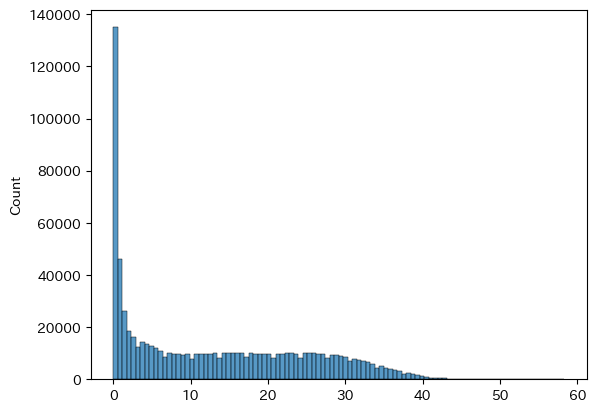

In [16]:
sns.histplot(df_elevation["average_slope_angle"], bins=100)

<module 'matplotlib.pyplot' from '/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

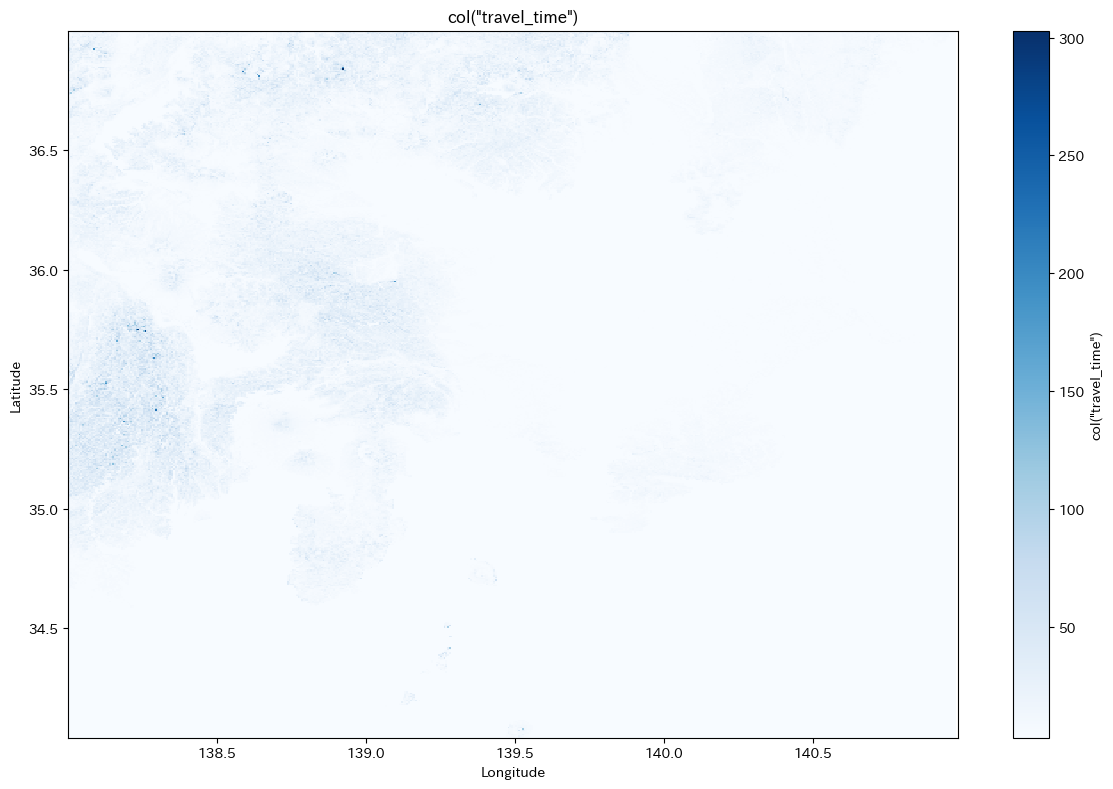

In [30]:
create_elevation_heatmap(df_elevation, pl.col("travel_time"), "x", "y", cmap='Blues')

<Axes: xlabel='x', ylabel='walking_velocity'>

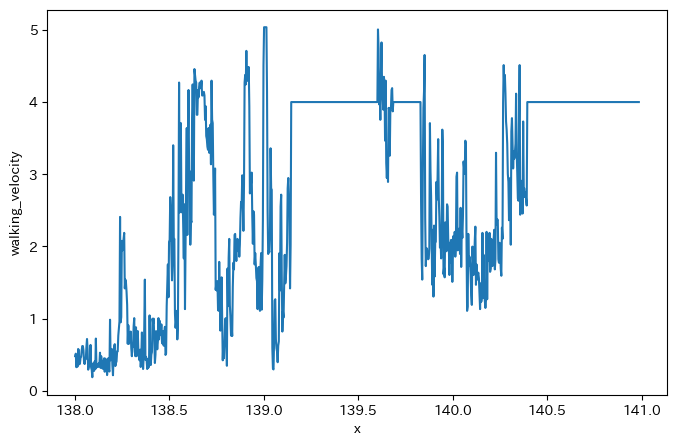

In [31]:
df_cut = df_elevation.filter(pl.col("grid_y") == np.random.randint(0, df_elevation["grid_y"].max()))

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_cut.to_pandas(), x="x", y="walking_velocity")

In [32]:
# save
df_elevation.write_csv("../data/10_1_gdf_elevation_tobler.csv")

- 時期の分け方
    - 早々期、早期
    - 前期
    - 中期
    - 後期
    - 晩期
        - 晩期は後期とセットでも良い
  - 早期〜晩期(五領ヶ台Ⅱ〜阿玉台前半主体)は中期〜前期→中期
  - 早期〜後期(条痕文系が6割程度)は早期〜早期後葉→早期

In [33]:
df_elevation

grid_x,x,grid_y,y,mesh_code_5th,average_elevation,maximum_elevation,minimum_elevation,minimum_elevation_code,maximum_slope_angle,maximum_slope_direction,minimum_slope_angle,minimum_slope_direction,average_slope_angle,geometry,is_sea,walking_velocity,travel_time,elevation_diff_east,angle_east,walking_velocity_east,travel_time_east,elevation_diff_west,angle_west,walking_velocity_west,travel_time_west,elevation_diff_north,angle_north,walking_velocity_north,travel_time_north,elevation_diff_south,angle_south,walking_velocity_south,travel_time_south
i64,f64,i64,f64,i64,f64,f64,f64,str,f64,str,f64,str,f64,str,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,138.001563,0,34.042708,null,null,null,null,null,null,null,null,null,null,null,true,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656
0,138.001563,1,34.044792,null,null,null,null,null,null,null,null,null,null,null,true,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656
0,138.001563,2,34.046875,null,null,null,null,null,null,null,null,null,null,null,true,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656
0,138.001563,3,34.048958,null,null,null,null,null,null,null,null,null,null,null,true,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656
0,138.001563,4,34.051042,null,null,null,null,null,null,null,null,null,null,null,true,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
955,140.985938,1415,36.990625,5540378844,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((140.98437500001108 3…",false,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656
955,140.985938,1416,36.992708,5540379822,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((140.98437500001108 3…",false,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656
955,140.985938,1417,36.994792,5540379824,null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((140.98437500001108 3…",false,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656


In [34]:
df_elevation = pl.read_csv("../data/10_2_gdf_elevation_with_costs.csv")

<module 'matplotlib.pyplot' from '/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

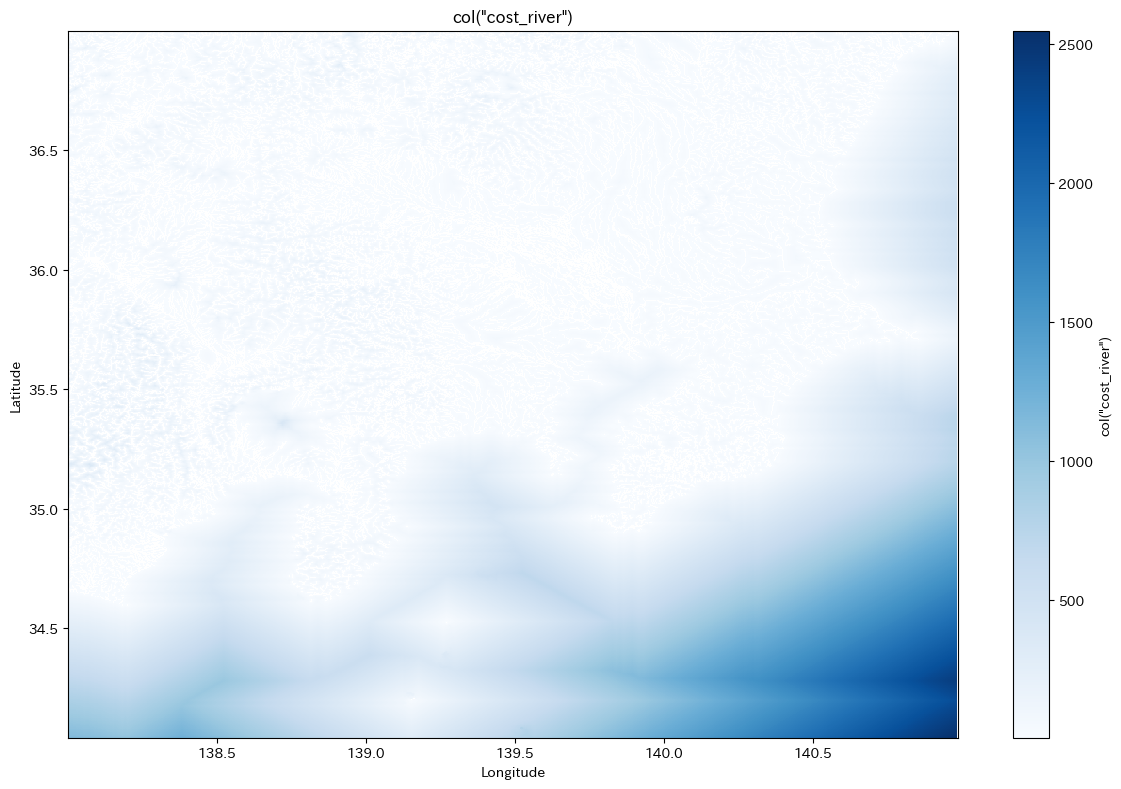

In [35]:
create_elevation_heatmap(df_elevation, pl.col("cost_river"), "x", "y", cmap="Blues", resolution=900)